<a href="https://colab.research.google.com/github/BankNatchapol/Comparison-Of-Quantum-Gradient/blob/main/discrete_vs_continuous/parameter_shift_rule.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pennylane-sf

In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import GradientDescentOptimizer

import pandas as pd

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

# **Discrete-variable**

In [ ]:
num_wires = 1
dev = qml.device("default.qubit", wires=num_wires)

## Parameter shift rule

In [ ]:
def parameter_shift_term(qnode, params, i, j):
    
    shifted = params.copy()
    
    shifted[i, j] += np.pi/2
    forward = qnode(shifted)  # forward evaluation

    shifted[i, j] -= np.pi
    backward = qnode(shifted) # backward evaluation

    return 0.5 * (forward - backward)

def parameter_shift(qnode, params):
    gradients = np.zeros_like((params))
    for i in range(len(gradients)):
        for j in range(len(gradients[0])):
            gradients[i, j] += parameter_shift_term(qnode, params, i, j)

    return gradients

## Quantum gate estimation
Using $U3(1.44, 0.8, 2.1)$ as target gate

In [ ]:
# problem gate 
def problem():
    qml.U3(1.44, 0.8, 2.1, wires=0)

Ansatz for estimating target gate

In [ ]:
# guesting ansatz state
def ansatz(var):
    for wire in range(num_wires):
      qml.Hadamard(wires=wire)
      qml.RX(var[0+wire], wires=wire)
      qml.RY(var[1+wire], wires=wire)
      qml.RZ(var[2+wire], wires=wire)

Objective function <br> 
1. initial state is  $|0⟩$
2. apply target gate $U(\theta)|0⟩$ <br> 
the state will be $|\psi⟩ = a|0⟩+b|1⟩$ 
3. apply ansatz $A(\alpha)$  <br> 
the state will be $A(\alpha)|\psi⟩ = |\psi'⟩$
4. if $A(\alpha) = U(\theta)$ then  $|\psi'⟩= 1|0⟩ + 0|1⟩ = |0⟩$
5. so, we will minimize $b|1⟩$ to target $0|1⟩$ to make $A(\alpha) = U(\theta)$


In [ ]:
# objective function
@qml.qnode(dev)
def cost_function(var):
    for v in var: 
      ansatz(v)

    problem() # problem gate 

    return qml.expval(qml.Projector([1],wires=0)) # get amplitude of of |1>

Probability distribution of target gate 

In [ ]:
# target result of problem gate
@qml.qnode(dev)
def target():
    problem()
    return qml.probs(wires=[0])  # get target probability

Probability distribution of estimated gate 

In [ ]:
# prediction circuit
@qml.qnode(dev)
def prediction(var):
    for v in var:
      ansatz(v)
    return qml.probs(wires=[0])  # get prediction probability

In [ ]:
print("Target state: ", target())

Target state:  [0.56521185 0.43478815]


In [ ]:
np.random.seed(1)
num_layers = 2
var_init = 0.05*np.random.randn(num_layers, 3*num_wires)

In [ ]:
print("Initial cost: ", cost_function(var_init))

Initial cost:  0.38420647954293236


Training with parameter shift rule and gradient descent optimizer

In [ ]:
opt = GradientDescentOptimizer(0.01)

var = var_init.copy()
loss_plot = []

for it in range(1201):# while True:
    var, _cost = opt.step_and_cost(lambda v: cost_function(v), var, 
                                   grad_fn=lambda var: parameter_shift(cost_function, var)) 
    loss_plot.append(_cost)

    if it%100==0:
      print("Iter: {:5d} | Cost: {:0.11f} ".format(it, _cost))

Iter:     0 | Cost: 0.38420647954 
Iter:   100 | Cost: 0.07905926083 
Iter:   200 | Cost: 0.01260131677 
Iter:   300 | Cost: 0.00204853691 
Iter:   400 | Cost: 0.00034842518 
Iter:   500 | Cost: 0.00006112723 
Iter:   600 | Cost: 0.00001091990 
Iter:   700 | Cost: 0.00000197059 
Iter:   800 | Cost: 0.00000035761 
Iter:   900 | Cost: 0.00000006510 
Iter:  1000 | Cost: 0.00000001187 
Iter:  1100 | Cost: 0.00000000217 
Iter:  1200 | Cost: 0.00000000040 


In [ ]:
#@title 
fig = px.line(pd.DataFrame({"Iteration":range(len(loss_plot)), "Loss":loss_plot}), 
                          x="Iteration", y="Loss", title="Discrete-variable loss", width=1000)
fig.show()

In [ ]:
print("Target probs    : ", target())
print("Prediction probs: ", prediction(var))

Target probs    :  [0.56521185 0.43478815]
Prediction probs:  [0.56522923 0.43477077]


# **Continuous-variable**

In [ ]:
num_wires_cv = 1
dev_cv = qml.device("strawberryfields.fock", wires=num_wires_cv, cutoff_dim=20)

## Parameter shift rule

In [ ]:
gate_list = ['R', 'S1', 'D1'] 

def parameter_shift_cv_term(qnode, params, i, j):
    
    gate = gate_list[j%len(gate_list)]

    shifted = params.copy()

    if gate == 'R' or gate == 'S2' or gate == 'D2':
      shifted[i, j] += alpha
      forward = qnode(shifted)  # forward evaluation

      shifted[i, j] -= 2*alpha
      backward = qnode(shifted) # backward evaluation

      return (1/2) * (forward - backward)

    elif gate == 'S1':
      shifted[i, j] += s
      forward = qnode(shifted)  # forward evaluation

      shifted[i, j] -= 2*s
      backward = qnode(shifted) # backward evaluation

      return (1/(2*np.sinh(s))) * (forward - backward)
    
    elif gate == 'D1':
      shifted[i, j] += s
      forward = qnode(shifted)  # forward evaluation

      shifted[i, j] -= 2*s
      backward = qnode(shifted) # backward evaluation

      return (1/(2*s)) * (forward - backward)

def parameter_shift_cv(qnode, params):
    gradients = np.zeros_like((params))
    for i in range(len(gradients)):
        for j in range(len(gradients[0])):
            gradients[i, j] += parameter_shift_cv_term(qnode, params, i, j)

    return gradients

## Quantum gate estimation
Using $S(0.49, 0.2)D(0.395, 0.5)$ as target gate

In [ ]:
def problem_cv():
    qml.Squeezing(0.49, 0.2, wires=0)
    qml.Displacement(0.395, 0.5, wires=0)

Ansatz for estimating target gate

In [ ]:
def ansatz_cv(var):
    for wire in range(num_wires_cv):
      qml.Rotation(var[0+wire], wires=wire)
      qml.Squeezing(var[1+wire], 0.0, wires=wire)
      qml.Displacement(var[2+wire], 0.0, wires=wire)

Objective function <br> 
1. initial state is  $|0⟩$
2. apply target gate $U(r, \theta)|0⟩$ <br> 
photon number expectation value $⟨n⟩$
3. apply ansatz $A(s, \alpha)$  and $U(r, \theta)$<br> 
photon number expectation value $A(s, \alpha)U(r, \theta)|0⟩ = ⟨n'⟩$
4. if $⟨n'⟩ = 0$ then  $A(s, \alpha) = U^\dagger(r, \theta)$
5. so, we will minimize $⟨n'⟩$ to target $0$ to make $A(s, \alpha) = U^\dagger(r, \theta)$


In [ ]:
@qml.qnode(dev_cv)
def cost_function_cv(var):
    for v in var:
      ansatz_cv(v)

    problem_cv()

    return qml.expval(qml.NumberOperator(wires=0))

Probability distribution of target gate

In [ ]:
@qml.qnode(dev_cv)
def target_cv():
    problem_cv()

    return qml.probs(wires=0) #qml.NumberOperator(wires=0)

Probability distribution of estimated gate

In [ ]:
@qml.qnode(dev_cv)
def prediction_cv(var):
    for v in var:
      ansatz_cv(v)
    
    return qml.probs(wires=0)

Target expectation:  0.4159658082195514


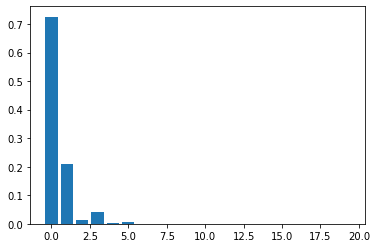

In [ ]:
t_cv = target_cv()
plt.bar(range(len(t_cv)),t_cv)
print("Target expectation: ", sum(range(len(t_cv))*t_cv))

In [ ]:
np.random.seed(1)
num_layers_cv = 2
var_init_cv = 0.05*np.random.randn(num_layers_cv, 3*num_wires_cv)

In [ ]:
print("Initial cost: ", cost_function_cv(var_init_cv))

Initial cost:  0.38494228126401864


Training with parameter shift rule and gradient descent optimizer

In [ ]:
opt_cv = GradientDescentOptimizer(0.01)

s = 0.1
alpha = np.pi/2

disc = 1
check_prev = 3

var_cv = var_init_cv.copy()
loss_plot_cv = []
break_count = 0


for it in range(1201):# while True:
    var_cv, _cost = opt.step_and_cost(lambda v: cost_function_cv(v), var_cv, 
                                   grad_fn=lambda var_cv: parameter_shift_cv(cost_function_cv, var_cv)) 
    
    loss_plot_cv.append(_cost)

    if it%100==0:
      print("Iter: {:5d} | Cost: {:0.11f} ".format(it, _cost))

Iter:     0 | Cost: 0.38494228126 
Iter:   100 | Cost: 0.07176909118 
Iter:   200 | Cost: 0.05033600473 
Iter:   300 | Cost: 0.03014311292 
Iter:   400 | Cost: 0.01913000554 
Iter:   500 | Cost: 0.01183261605 
Iter:   600 | Cost: 0.00480398702 
Iter:   700 | Cost: 0.00152150328 
Iter:   800 | Cost: 0.00046310143 
Iter:   900 | Cost: 0.00014622720 
Iter:  1000 | Cost: 0.00004904791 
Iter:  1100 | Cost: 0.00001839819 
Iter:  1200 | Cost: 0.00000856855 


In [ ]:
#@title 
fig = px.line(pd.DataFrame({"Iteration":range(len(loss_plot_cv)), "Loss":loss_plot_cv}), 
                          x="Iteration", y="Loss", title="Continuous-variable loss", width=1000)
fig.show()

In [ ]:
#@title 
t_cv = target_cv()
p_cv = prediction_cv(var_cv)
print("Target expectation    : ", sum(range(len(t_cv))*t_cv))
print("Prediction expectation: ", sum(range(len(p_cv))*p_cv))

fig = go.Figure(data=[
    go.Bar(name='Actual', x=np.array(range(len(t_cv))).astype(str), y=t_cv),
    go.Bar(name='Prediction', x=np.array(range(len(t_cv))).astype(str), y=p_cv)
])

fig.update_layout(title_text='State comparison')
fig.show()

Target expectation    :  0.4159658082195514
Prediction expectation:  0.6207780025056077


# **Discrete vs Continuous variable**

In [ ]:
#@title 
dv = pd.DataFrame({"Iteration":range(len(loss_plot)), "Loss":loss_plot})
cv = pd.DataFrame({"Iteration":range(len(loss_plot_cv)), "Loss":loss_plot_cv})

fig = go.Figure()
fig.add_trace(go.Scatter(x=dv["Iteration"], y=dv["Loss"], mode="lines", name="Discrete"))
fig.add_trace(go.Scatter(x=cv["Iteration"], y=cv["Loss"], mode="lines", name="Continuous"))
fig.update_layout(title_text='Discrete vs Continuous loss')
fig.show()